# Clustering analysis for the State of Arizona

Initial Comments:
- correlation between products is strong - perhaps because we've localized to a specific geographic region
    - this also means that probably clustering tending to group more products together in one cluster because of higher similarity
- natl seems to be particularly different than the rest
- why do optics and dbscan pick up on opposite outliers?

Kmeans- separates xu and liu

hierarchical- separates xu and liu

DBSCAN- separates xu natl liu

OPTICS- separates esa and ltgnn

In [26]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans, AffinityPropagation, OPTICS, MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from utils import *

In [2]:
# Load the dataset
biomass_data = pd.read_csv('agb_AZ_final.csv')

In [3]:
biomass_data

,product,agb_Mg_ha,year,IGBP_Class,Longitude,Latitude,IGBP_Name,ffp_radius
0,chopping,NaN,Average_2010-2011-2012-2013-2014-2015-2016-201...,1,-118.502698,36.228055,Evergreen Needleleaf Forest,1
1,chopping,-9999.0,Average_2010-2011-2012-2013-2014-2015-2016-201...,1,-115.103417,35.283820,Evergreen Needleleaf Forest,1
2,chopping,NaN,Average_2010-2011-2012-2013-2014-2015-2016-201...,1,-117.900180,36.335968,Evergreen Needleleaf Forest,1
3,chopping,-9999.0,Average_2010-2011-2012-2013-2014-2015-2016-201...,1,-108.709532,33.620168,Evergreen Needleleaf Forest,1
4,chopping,0.0,Average_2010-2011-2012-2013-2014-2015-2016-201...,1,-112.648381,32.127377,Evergreen Needleleaf Forest,1
...,...,...,...,...,...,...,...,...
54005,xu,0.0,Average_2010-2011-2012-2013-2014-2015-2016-201...,17,-109.671763,34.744257,NaN,1
54006,xu,NaN,Average_2010-2011-2012-2013-2014-2015-2016-201...,17,-117.414568,35.787412,NaN,1
54007,xu,NaN,Average_2010-2011-2012-2013-2014-2015-2016-201...,17,-107.387590,33.907935,NaN,1
54008,xu,NaN,Average_2010-2011-2012-2013-2014-2015-2016-201...,17,-121.371403,39.546367,NaN,1


In [5]:
#Drop the year column
biomass_data = biomass_data.drop('year', axis=1)
biomass_data

,product,agb_Mg_ha,IGBP_Class,Longitude,Latitude,IGBP_Name,ffp_radius,location_id
0,chopping,NaN,1,-118.502698,36.228055,Evergreen Needleleaf Forest,1,-118.5026978_36.22805529
1,chopping,-9999.0,1,-115.103417,35.283820,Evergreen Needleleaf Forest,1,-115.1034173_35.28382012
2,chopping,NaN,1,-117.900180,36.335968,Evergreen Needleleaf Forest,1,-117.9001799_36.33596788
3,chopping,-9999.0,1,-108.709532,33.620168,Evergreen Needleleaf Forest,1,-108.7095324_33.62016768
4,chopping,0.0,1,-112.648381,32.127377,Evergreen Needleleaf Forest,1,-112.6483813_32.12737684
...,...,...,...,...,...,...,...,...
54005,xu,0.0,17,-109.671763,34.744257,NaN,1,-109.6717626_34.74425716
54006,xu,NaN,17,-117.414568,35.787412,NaN,1,-117.4145683_35.78741221
54007,xu,NaN,17,-107.387590,33.907935,NaN,1,-107.3875899_33.90793458
54008,xu,NaN,17,-121.371403,39.546367,NaN,1,-121.3714029_39.54636745


In [6]:
df=biomass_data

# Get unique product categories
unique_products = df['product'].unique()

# Create a dictionary to store separate dataframes
product_dfs = {}

# Separate the dataframe for each unique product
for product in unique_products:
    product_dfs[product] = df[df['product'] == product].copy()
    
    # Reset index for each separated dataframe
    product_dfs[product].reset_index(drop=True, inplace=True)

In [7]:
#Combine agb data for all products into one dataframe, locations on rows, products on cols

# Create an empty dataframe to store the combined 'agb_MG_ha' columns
combined_df = pd.DataFrame()

# Append 'agb_MG_ha' column for each product category into the combined dataframe
for product in unique_products:
    # Extract the 'agb_MG_ha' column for the current product category
    product_agb = product_dfs[product]['agb_Mg_ha'].reset_index(drop=True)
    
    # Rename the column to indicate the product category
    product_agb.name = f'{product}'
    
    # Append the column to the combined dataframe
    combined_df = pd.concat([combined_df, product_agb], axis=1)

In [8]:
combined_df

,chopping,esa,gedi,gfw,harmonized,liu,ltgnn,menlove,natl,xu
0,NaN,NaN,NaN,NaN,445.0,NaN,NaN,NaN,NaN,NaN
1,-9999.0,-9999.000000,NaN,NaN,3.0,NaN,-9999.000000,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
3,-9999.0,-9999.000000,NaN,NaN,NaN,NaN,-9999.000000,NaN,NaN,NaN
4,0.0,3.227728,6.378667,NaN,NaN,9.633644,0.523012,0.000000,0.0,7.75922
...,...,...,...,...,...,...,...,...,...,...
5396,0.0,0.000000,0.352851,NaN,NaN,8.560379,0.000000,0.801399,0.0,0.00000
5397,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
5398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5399,NaN,NaN,NaN,NaN,780.0,NaN,NaN,NaN,NaN,NaN


In [10]:
# Prep data for clustering

# Remove non-numeric rows
data_transposed_numeric = combined_df.select_dtypes(include=[np.number])

# Replace 'NA' with NaN
data_transposed_numeric = data_transposed_numeric.replace('NA', np.nan)

# Drop rows with all NaN values
data_transposed_numeric = data_transposed_numeric.dropna(axis=1, how='all')

# Impute missing values with column mean
imputer = SimpleImputer(strategy='mean')
# Impute missing values with ROW mean (must use transposed df and axis=1 for rows)
data_imputed = data_transposed_numeric.T.fillna(data_transposed_numeric.mean(axis=1)).T

In [11]:
data_imputed

,chopping,esa,gedi,gfw,harmonized,liu,ltgnn,menlove,natl,xu
0,445.0,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.0,445.00000
1,-9999.0,-9999.000000,-7498.500000,-7498.500000,3.000000,-7498.500000,-9999.000000,-7498.500000,-7498.5,-7498.50000
2,2.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.00000
3,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.00000
4,0.0,3.227728,6.378667,3.440284,3.440284,9.633644,0.523012,0.000000,0.0,7.75922
...,...,...,...,...,...,...,...,...,...,...
5396,0.0,0.000000,0.352851,1.214329,1.214329,8.560379,0.000000,0.801399,0.0,0.00000
5397,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0,4.00000
5398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5399,780.0,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.0,780.00000


In [ ]:
#add back information columns. this df IS NOT used for clustering, just for reference
# full_df=pd.concat([data_imputed,product_dfs['chopping']['Latitude']], axis=1)
# full_df=pd.concat([full_df,product_dfs['chopping']['Longitude']], axis=1)
# full_df=pd.concat([full_df,product_dfs['chopping']['IGBP_Name']], axis=1)
# full_df=pd.concat([full_df,product_dfs['chopping']['IGBP_Class']], axis=1)
# full_df=pd.concat([full_df,product_dfs['chopping']['ffp_radius']], axis=1)
# full_df=full_df.dropna(how='any')
# full_df

In [12]:
#remove any row that has a NaN value (if any one product is NaN at a location, we want to exclude it)
data_imputed=data_imputed.dropna(how='any')
data_imputed

,chopping,esa,gedi,gfw,harmonized,liu,ltgnn,menlove,natl,xu
0,445.0,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000
1,-9999.0,-9999.000000,-7498.500000,-7498.500000,3.000000,-7498.500000,-9999.000000,-7498.500000,-7498.500000,-7498.500000
2,2.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
3,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
4,0.0,3.227728,6.378667,3.440284,3.440284,9.633644,0.523012,0.000000,0.000000,7.759220
...,...,...,...,...,...,...,...,...,...,...
5393,7.0,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
5395,19.0,26.000000,10.393441,29.645032,29.645032,23.127108,18.750000,8.280436,74.609993,56.999275
5396,0.0,0.000000,0.352851,1.214329,1.214329,8.560379,0.000000,0.801399,0.000000,0.000000
5397,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [15]:
#transpose dataset for clustering
data_transposed = data_imputed.T
data_transposed

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_transposed)

,0,1,2,3,4,6,8,9,10,11,...,5387,5389,5390,5391,5392,5393,5395,5396,5397,5399
chopping,445.0,-9999.0,2.0,-9999.0,0.000000,10.909091,654.0,0.000000,0.000000,8.0,...,0.000000,-9999.00,987.0,39.0,-9999.0,7.0,19.000000,0.000000,4.0,780.0
esa,445.0,-9999.0,2.0,-9999.0,3.227728,0.000000,654.0,0.000000,0.600000,8.0,...,0.000000,-9999.00,987.0,39.0,-9999.0,7.0,26.000000,0.000000,4.0,780.0
gedi,445.0,-7498.5,2.0,-9999.0,6.378667,1.506807,654.0,1.462118,2.575745,8.0,...,7.972266,-7498.75,987.0,39.0,-9999.0,7.0,10.393441,0.352851,4.0,780.0
gfw,445.0,-7498.5,2.0,-9999.0,3.440284,16.497722,654.0,1.683489,2.829606,8.0,...,2.482773,-7498.75,987.0,39.0,-9999.0,7.0,29.645032,1.214329,4.0,780.0
harmonized,445.0,3.0,2.0,-9999.0,3.440284,16.497722,654.0,1.683489,2.829606,8.0,...,2.482773,2.00,987.0,39.0,-9999.0,7.0,29.645032,1.214329,4.0,780.0
liu,445.0,-7498.5,2.0,-9999.0,9.633644,10.597534,654.0,9.854346,8.008692,8.0,...,9.032247,-7498.75,987.0,39.0,-9999.0,7.0,23.127108,8.560379,4.0,780.0
ltgnn,445.0,-9999.0,2.0,-9999.0,0.523012,0.250000,654.0,0.000000,10.915918,8.0,...,0.000000,-9999.00,987.0,39.0,-9999.0,7.0,18.750000,0.000000,4.0,780.0
menlove,445.0,-7498.5,2.0,-9999.0,0.000000,0.000000,654.0,2.151451,0.000000,8.0,...,0.431019,-7498.75,987.0,39.0,-9999.0,7.0,8.280436,0.801399,4.0,780.0
natl,445.0,-7498.5,2.0,-9999.0,0.000000,40.949997,654.0,0.000000,0.000000,8.0,...,0.000000,-7498.75,987.0,39.0,-9999.0,7.0,74.609993,0.000000,4.0,780.0
xu,445.0,-7498.5,2.0,-9999.0,7.759220,67.768349,654.0,0.000000,0.536493,8.0,...,2.426653,-7498.75,987.0,39.0,-9999.0,7.0,56.999275,0.000000,4.0,780.0


# hierarchical

In [39]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Initialize variables to store the best results for each index
best_n_silhouette = 0
best_silhouette = -1.0

best_n_calinski_harabasz = 0
best_calinski_harabasz = -1.0

best_n_davies_bouldin = 0
best_davies_bouldin = float('inf')

for n_clusters in range(2, 7):  # Start from 2 clusters
    print(f"n_clusters = {n_clusters}")
    
    # Hierarchical clustering
    cluster_h = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    clusters_h = cluster_h.fit_predict(data_scaled)
    
    # Compute evaluation metrics
    silhouette = silhouette_score(data_scaled, clusters_h)
    calinski_harabasz = calinski_harabasz_score(data_scaled, clusters_h)
    davies_bouldin = davies_bouldin_score(data_scaled, clusters_h)
    
    print(f"Silhouette Index: {silhouette:.4f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
    
    # Update the best results for Silhouette Index
    if silhouette > best_silhouette:
        best_n_silhouette = n_clusters
        best_silhouette = silhouette
    
    # Update the best results for Calinski-Harabasz Index
    if calinski_harabasz > best_calinski_harabasz:
        best_n_calinski_harabasz = n_clusters
        best_calinski_harabasz = calinski_harabasz
    
    # Update the best results for Davies-Bouldin Index
    if davies_bouldin < best_davies_bouldin:
        best_n_davies_bouldin = n_clusters
        best_davies_bouldin = davies_bouldin
    
    print("---")

print("Best results for each index:")
print(f"Silhouette Index - Optimal n_clusters: {best_n_silhouette}, Best Silhouette Index: {best_silhouette:.4f}")
print(f"Calinski-Harabasz Index - Optimal n_clusters: {best_n_calinski_harabasz}, Best Calinski-Harabasz Index: {best_calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index - Optimal n_clusters: {best_n_davies_bouldin}, Best Davies-Bouldin Index: {best_davies_bouldin:.4f}")

n_clusters = 2
Silhouette Index: 0.3647
Calinski-Harabasz Index: 5.4739
Davies-Bouldin Index: 0.9931
---
n_clusters = 3
Silhouette Index: 0.2503
Calinski-Harabasz Index: 4.4406
Davies-Bouldin Index: 0.8035
---
n_clusters = 4
Silhouette Index: 0.2346
Calinski-Harabasz Index: 4.8788
Davies-Bouldin Index: 0.4215
---
n_clusters = 5
Silhouette Index: 0.0991
Calinski-Harabasz Index: 4.9678
Davies-Bouldin Index: 0.7939
---
n_clusters = 6
Silhouette Index: 0.1189
Calinski-Harabasz Index: 4.8877
Davies-Bouldin Index: 0.7390
---
Best results for each index:
Silhouette Index - Optimal n_clusters: 2, Best Silhouette Index: 0.3647
Calinski-Harabasz Index - Optimal n_clusters: 2, Best Calinski-Harabasz Index: 5.4739
Davies-Bouldin Index - Optimal n_clusters: 4, Best Davies-Bouldin Index: 0.4215


Cluster labels: [1 1 1 1 1 0 1 1 2 0]
Distances between cluster centers:
[[ 0.         62.46952103 89.70112651]
 [62.46952103  0.         53.20050558]
 [89.70112651 53.20050558  0.        ]]

Distances between data points and cluster centers:
Data point 0: [80.99286813 30.00391494 57.57077088]
Data point 1: [72.34020052 22.28052051 56.52543683]
Data point 2: [63.50835997 31.1478028  66.90006357]
Data point 3: [52.75159171 16.77189073 52.86859089]
Data point 4: [58.43304852 29.81945998 58.54259732]
Data point 5: [ 34.84873272  79.52034853 104.43830787]
Data point 6: [71.92780169 23.45622501 58.30112309]
Data point 7: [69.47889016 24.89411516 62.55257729]
Data point 8: [89.70112651 53.20050558  0.        ]
Data point 9: [34.84873272 62.5321088  87.25876683]
biomass_data_clustered has more columns than rows, clustering occured on products
Cluster 1 contains multiple products, plotting heatmap...
Cluster 0 contains multiple products, plotting heatmap...


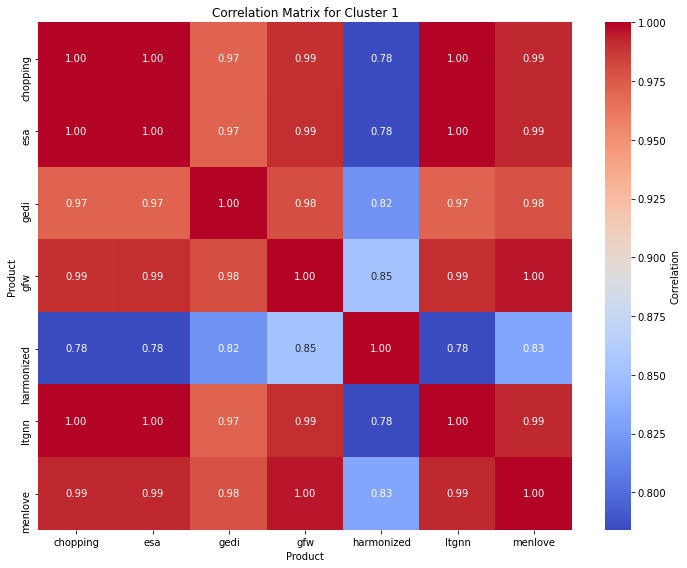

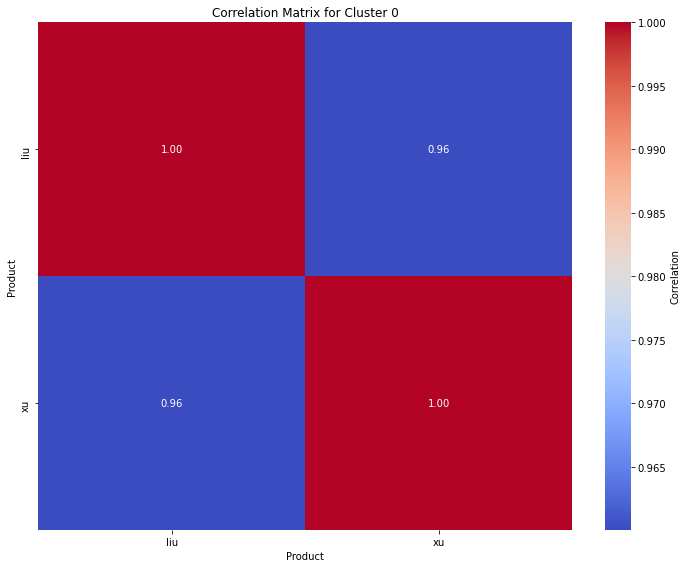

Silhouette Coefficient: 0.2502729283346145
Calinski-Harabasz Index: 4.440591296279918
Davies-Bouldin Index: 0.8035017591522883


In [37]:
#hierarchical clustering
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
clusters = agg.fit_predict(data_scaled)
labels = agg.labels_
print("Cluster labels:", clusters)

cluster_distances=get_dist(data_scaled, labels)

# Add cluster labels to the transposed DataFrame
data_transposed.loc[:,'cluster'] = clusters

# Transpose the data back to the original format
biomass_data_clustered = data_transposed.reset_index()
biomass_data_clustered

# List of products
products = ['chopping', 'esa', 'gedi', 'gfw', 'harmonized', 'liu', 'ltgnn','menlove','natl','xu']
corr_matrix=plot_heat_by_clus(biomass_data_clustered,products)

# METRICS
# Extract predicted cluster labels
predicted_labels = biomass_data_clustered['cluster']
print_indices(data_scaled, predicted_labels)

In [38]:
biomass_data_clustered

,index,0,1,2,3,4,6,8,9,10,...,5389,5390,5391,5392,5393,5395,5396,5397,5399,cluster
0,chopping,445.0,-9999.0,2.0,-9999.0,0.000000,10.909091,654.0,0.000000,0.000000,...,-9999.00,987.0,39.0,-9999.0,7.0,19.000000,0.000000,4.0,780.0,1
1,esa,445.0,-9999.0,2.0,-9999.0,3.227728,0.000000,654.0,0.000000,0.600000,...,-9999.00,987.0,39.0,-9999.0,7.0,26.000000,0.000000,4.0,780.0,1
2,gedi,445.0,-7498.5,2.0,-9999.0,6.378667,1.506807,654.0,1.462118,2.575745,...,-7498.75,987.0,39.0,-9999.0,7.0,10.393441,0.352851,4.0,780.0,1
3,gfw,445.0,-7498.5,2.0,-9999.0,3.440284,16.497722,654.0,1.683489,2.829606,...,-7498.75,987.0,39.0,-9999.0,7.0,29.645032,1.214329,4.0,780.0,1
4,harmonized,445.0,3.0,2.0,-9999.0,3.440284,16.497722,654.0,1.683489,2.829606,...,2.00,987.0,39.0,-9999.0,7.0,29.645032,1.214329,4.0,780.0,1
5,liu,445.0,-7498.5,2.0,-9999.0,9.633644,10.597534,654.0,9.854346,8.008692,...,-7498.75,987.0,39.0,-9999.0,7.0,23.127108,8.560379,4.0,780.0,0
6,ltgnn,445.0,-9999.0,2.0,-9999.0,0.523012,0.250000,654.0,0.000000,10.915918,...,-9999.00,987.0,39.0,-9999.0,7.0,18.750000,0.000000,4.0,780.0,1
7,menlove,445.0,-7498.5,2.0,-9999.0,0.000000,0.000000,654.0,2.151451,0.000000,...,-7498.75,987.0,39.0,-9999.0,7.0,8.280436,0.801399,4.0,780.0,1
8,natl,445.0,-7498.5,2.0,-9999.0,0.000000,40.949997,654.0,0.000000,0.000000,...,-7498.75,987.0,39.0,-9999.0,7.0,74.609993,0.000000,4.0,780.0,2
9,xu,445.0,-7498.5,2.0,-9999.0,7.759220,67.768349,654.0,0.000000,0.536493,...,-7498.75,987.0,39.0,-9999.0,7.0,56.999275,0.000000,4.0,780.0,0


# Kmeans

In [40]:
# Initialize variables to store the best results for each index
best_n_silhouette = 0
best_silhouette = -1.0

best_n_calinski_harabasz = 0
best_calinski_harabasz = -1.0

best_n_davies_bouldin = 0
best_davies_bouldin = float('inf')

for n_clusters in range(2, 7):  # Start from 2 clusters
    print(f"n_clusters = {n_clusters}")
    
    # kmeans clustering
    cluster = KMeans(n_clusters=n_clusters)
    clusters = cluster.fit_predict(data_scaled)
    
    # Compute evaluation metrics
    silhouette = silhouette_score(data_scaled, clusters)
    calinski_harabasz = calinski_harabasz_score(data_scaled, clusters)
    davies_bouldin = davies_bouldin_score(data_scaled, clusters)
    
    print(f"Silhouette Index: {silhouette:.4f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
    
    # Update the best results for Silhouette Index
    if silhouette > best_silhouette:
        best_n_silhouette = n_clusters
        best_silhouette = silhouette
    
    # Update the best results for Calinski-Harabasz Index
    if calinski_harabasz > best_calinski_harabasz:
        best_n_calinski_harabasz = n_clusters
        best_calinski_harabasz = calinski_harabasz
    
    # Update the best results for Davies-Bouldin Index
    if davies_bouldin < best_davies_bouldin:
        best_n_davies_bouldin = n_clusters
        best_davies_bouldin = davies_bouldin
    
    print("---")

print("Best results for each index:")
print(f"Silhouette Index - Optimal n_clusters: {best_n_silhouette}, Best Silhouette Index: {best_silhouette:.4f}")
print(f"Calinski-Harabasz Index - Optimal n_clusters: {best_n_calinski_harabasz}, Best Calinski-Harabasz Index: {best_calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index - Optimal n_clusters: {best_n_davies_bouldin}, Best Davies-Bouldin Index: {best_davies_bouldin:.4f}")

n_clusters = 2
Silhouette Index: 0.3647
Calinski-Harabasz Index: 5.4739
Davies-Bouldin Index: 0.9931
---
n_clusters = 3
Silhouette Index: 0.2503
Calinski-Harabasz Index: 4.4406
Davies-Bouldin Index: 0.8035
---
n_clusters = 4
Silhouette Index: 0.2346
Calinski-Harabasz Index: 4.8788
Davies-Bouldin Index: 0.4215
---
n_clusters = 5
Silhouette Index: 0.0991
Calinski-Harabasz Index: 4.9678
Davies-Bouldin Index: 0.7939
---
n_clusters = 6
Silhouette Index: 0.0815
Calinski-Harabasz Index: 4.6755
Davies-Bouldin Index: 0.7120
---
Best results for each index:
Silhouette Index - Optimal n_clusters: 2, Best Silhouette Index: 0.3647
Calinski-Harabasz Index - Optimal n_clusters: 2, Best Calinski-Harabasz Index: 5.4739
Davies-Bouldin Index - Optimal n_clusters: 4, Best Davies-Bouldin Index: 0.4215


Cluster labels: [1 1 1 1 1 2 1 1 0 2]
Distances between cluster centers:
[[ 0.         53.20050558 89.70112651]
 [53.20050558  0.         62.46952103]
 [89.70112651 62.46952103  0.        ]]

Distances between data points and cluster centers:
Data point 0: [57.57077088 30.00391494 80.99286813]
Data point 1: [56.52543683 22.28052051 72.34020052]
Data point 2: [66.90006357 31.1478028  63.50835997]
Data point 3: [52.86859089 16.77189073 52.75159171]
Data point 4: [58.54259732 29.81945998 58.43304852]
Data point 5: [104.43830787  79.52034853  34.84873272]
Data point 6: [58.30112309 23.45622501 71.92780169]
Data point 7: [62.55257729 24.89411516 69.47889016]
Data point 8: [ 0.         53.20050558 89.70112651]
Data point 9: [87.25876683 62.5321088  34.84873272]
biomass_data_clustered has more columns than rows, clustering occured on products
Cluster 1 contains multiple products, plotting heatmap...
Cluster 2 contains multiple products, plotting heatmap...


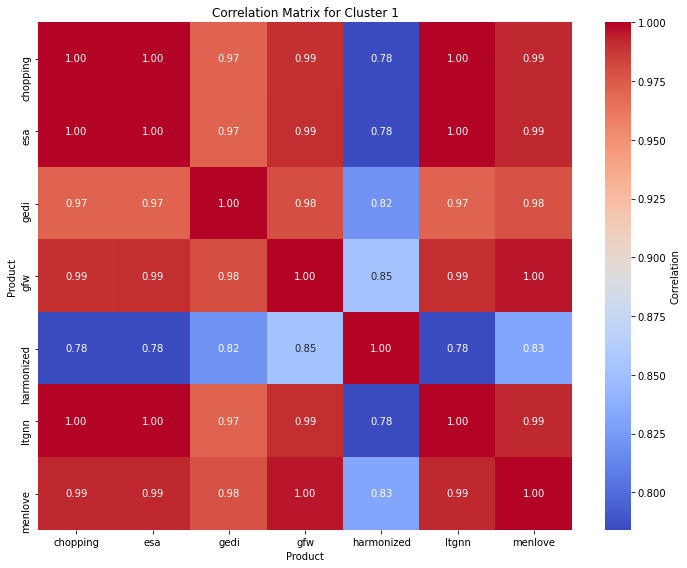

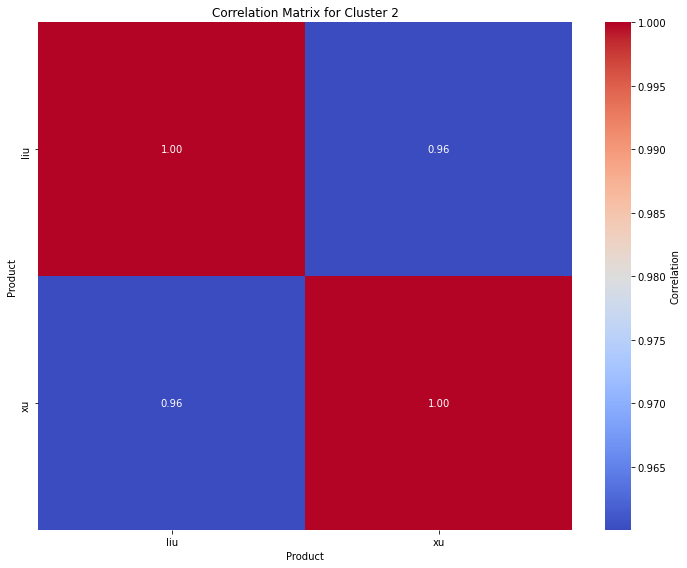

Silhouette Coefficient: 0.2502729283346145
Calinski-Harabasz Index: 4.440591296279918
Davies-Bouldin Index: 0.8035017591522883


In [41]:
# kmeans clustering
km = KMeans(n_clusters=3)
clusters = km.fit_predict(data_scaled)
labels = km.labels_
print("Cluster labels:", clusters)

cluster_distances=get_dist(data_scaled, labels)

# Add cluster labels to the transposed DataFrame
data_transposed.loc[:,'cluster'] = clusters

# Transpose the data back to the original format
biomass_data_clustered = data_transposed.reset_index()

# List of products
products = ['chopping', 'esa', 'gedi', 'gfw', 'harmonized', 'liu', 'ltgnn','menlove','natl','xu']
corr_matrix=plot_heat_by_clus(biomass_data_clustered,products)

# METRICS
# Extract predicted cluster labels
predicted_labels = biomass_data_clustered['cluster']
print_indices(data_scaled, predicted_labels)

# DBSCAN

In [24]:
# Define the range of values for eps and min_samples
eps_values = np.arange(20, 50, 2)
min_samples_values = range(4, 5)

# Initialize variables to store the best results for each index
best_eps_silhouette = 0
best_min_samples_silhouette = 0
best_silhouette = -1.0

best_eps_calinski_harabasz = 0
best_min_samples_calinski_harabasz = 0
best_calinski_harabasz = -1.0

best_eps_davies_bouldin = 0
best_min_samples_davies_bouldin = 0
best_davies_bouldin = float('inf')

min_samples=2
for eps in eps_values:
#     for min_samples in min_samples_values:
    print(f"eps = {eps:.2f}, min_samples = {min_samples}")

    # DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters_d = dbscan.fit_predict(data_scaled)

    # Add cluster labels to the transposed DataFrame
    data_transposed.loc[:,'cluster'] = clusters_d
    print(clusters_d)

    # Transpose the data back to the original format
    biomass_data_clustered_d = data_imputed.reset_index()

    # Check for noise points
    if -1 in clusters_d:
        print("Noise found during clustering, contained in cluster -1")

    # Compute evaluation metrics
    if len(set(clusters_d)) > 1:  # Check if there are at least two clusters
        silhouette = silhouette_score(data_scaled, clusters_d)
        calinski_harabasz = calinski_harabasz_score(data_scaled, clusters_d)
        davies_bouldin = davies_bouldin_score(data_scaled, clusters_d)

        print(f"Silhouette Index: {silhouette:.4f}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
        print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

        # Update the best results for Silhouette Index
        if silhouette > best_silhouette:
            best_eps_silhouette = eps
            best_min_samples_silhouette = min_samples
            best_silhouette = silhouette

        # Update the best results for Calinski-Harabasz Index
        if calinski_harabasz > best_calinski_harabasz:
            best_eps_calinski_harabasz = eps
            best_min_samples_calinski_harabasz = min_samples
            best_calinski_harabasz = calinski_harabasz

        # Update the best results for Davies-Bouldin Index
        if davies_bouldin < best_davies_bouldin:
            best_eps_davies_bouldin = eps
            best_min_samples_davies_bouldin = min_samples
            best_davies_bouldin = davies_bouldin
    else:
        print("Skipping evaluation metrics as there is only one cluster")

    print("---")

print("Best results for each index:")
print(f"Silhouette Index - Optimal eps: {best_eps_silhouette:.2f}, Optimal min_samples: {best_min_samples_silhouette}, Best Silhouette Index: {best_silhouette:.4f}")
print(f"Calinski-Harabasz Index - Optimal eps: {best_eps_calinski_harabasz:.2f}, Optimal min_samples: {best_min_samples_calinski_harabasz}, Best Calinski-Harabasz Index: {best_calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index - Optimal eps: {best_eps_davies_bouldin:.2f}, Optimal min_samples: {best_min_samples_davies_bouldin}, Best Davies-Bouldin Index: {best_davies_bouldin:.4f}")

eps = 20.00, min_samples = 2
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Noise found during clustering, contained in cluster -1
Skipping evaluation metrics as there is only one cluster
---
eps = 22.00, min_samples = 2
[-1  0 -1 -1 -1 -1  0 -1 -1 -1]
Noise found during clustering, contained in cluster -1
Silhouette Index: -0.0147
Calinski-Harabasz Index: 1.0002
Davies-Bouldin Index: 1.4732
---
eps = 24.00, min_samples = 2
[-1  0 -1 -1 -1 -1  0 -1 -1 -1]
Noise found during clustering, contained in cluster -1
Silhouette Index: -0.0147
Calinski-Harabasz Index: 1.0002
Davies-Bouldin Index: 1.4732
---
eps = 26.00, min_samples = 2
[-1  0 -1 -1 -1 -1  0 -1 -1 -1]
Noise found during clustering, contained in cluster -1
Silhouette Index: -0.0147
Calinski-Harabasz Index: 1.0002
Davies-Bouldin Index: 1.4732
---
eps = 28.00, min_samples = 2
[-1  0 -1 -1 -1 -1  0 -1 -1 -1]
Noise found during clustering, contained in cluster -1
Silhouette Index: -0.0147
Calinski-Harabasz Index: 1.0002
Davies-Bouldin Index: 1.4732

Cluster labels: [ 0  0  0  0  0 -1  0  0 -1 -1]
biomass_data_clustered has more columns than rows, clustering occured on products
Cluster 0 contains multiple products, plotting heatmap...
Cluster -1 contains multiple products, plotting heatmap...


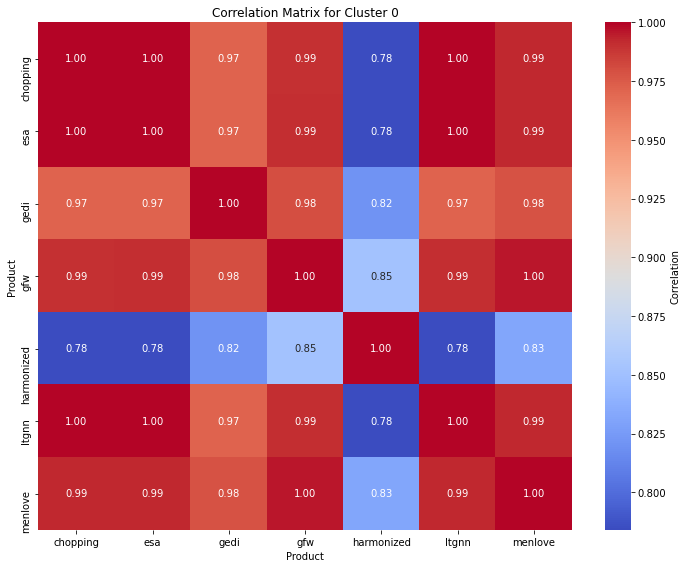

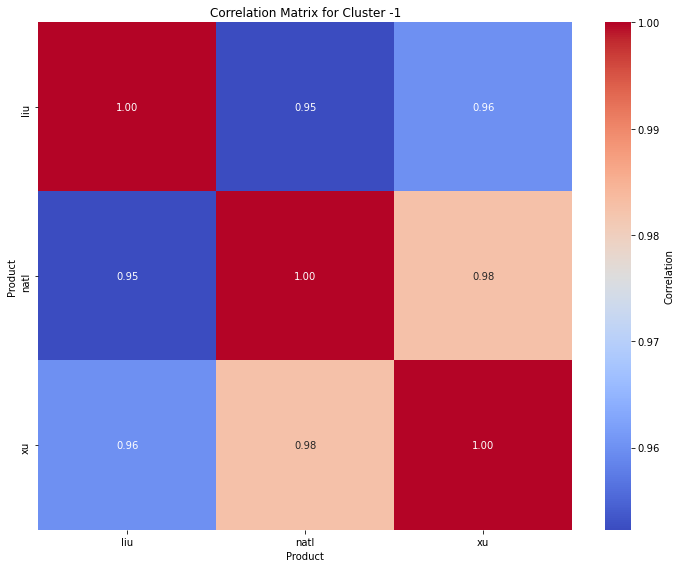

In [43]:
# DBSCAN clustering
dbscan = DBSCAN(eps=38, min_samples=2)  # Adjust the parameters as needed
clusters = dbscan.fit_predict(data_scaled)
labels = dbscan.labels_
print("Cluster labels:", clusters)

# cluster_distances=get_dist(data_scaled, labels)

# Add cluster labels to the transposed DataFrame
data_transposed.loc[:,'cluster'] = clusters

# Transpose the data back to the original format
biomass_data_clustered = data_transposed.reset_index()

# List of products
products = ['chopping', 'esa', 'gedi', 'gfw', 'harmonized', 'liu', 'ltgnn','menlove','natl','xu']
corr_matrix=plot_heat_by_clus(biomass_data_clustered,products)

# METRICS
# Extract predicted cluster labels
# predicted_labels = biomass_data_clustered['cluster']
# print_indices(data_scaled, predicted_labels)

### explore dbscan clusters by choice of epsilon and n

# Optics

OPTICS Cluster labels: [-1  0 -1 -1 -1 -1  0 -1 -1 -1]
Distances between cluster centers:
[[ 0.        33.5228617]
 [33.5228617  0.       ]]

Distances between data points and cluster centers:
Data point 0: [37.40357811 39.81102574]
Data point 1: [10.39641549 34.68480311]
Data point 2: [43.88221071 32.06227267]
Data point 3: [29.62644744 12.82497694]
Data point 4: [43.24430261 26.17730412]
Data point 5: [87.77068153 66.08225394]
Data point 6: [10.39641549 35.50633544]
Data point 7: [35.9710319  31.73979334]
Data point 8: [56.41575601 52.77408899]
Data point 9: [70.02298312 50.43566059]
biomass_data_clustered has more columns than rows, clustering occured on products
Cluster -1 contains multiple products, plotting heatmap...
Cluster 0 contains multiple products, plotting heatmap...


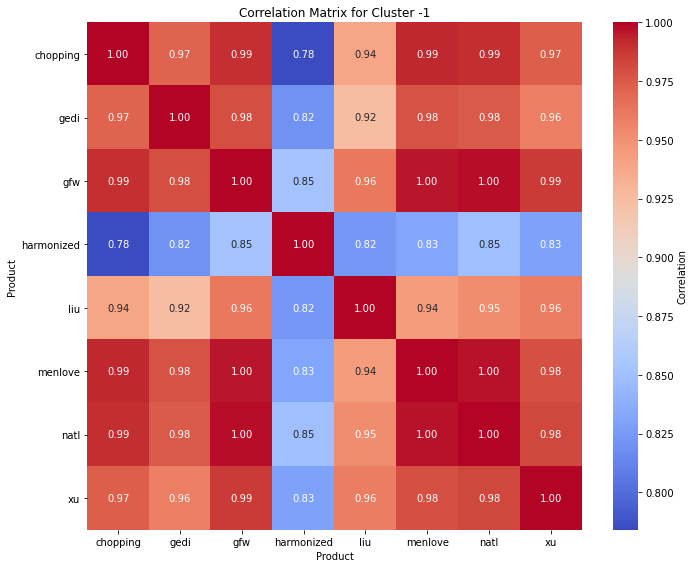

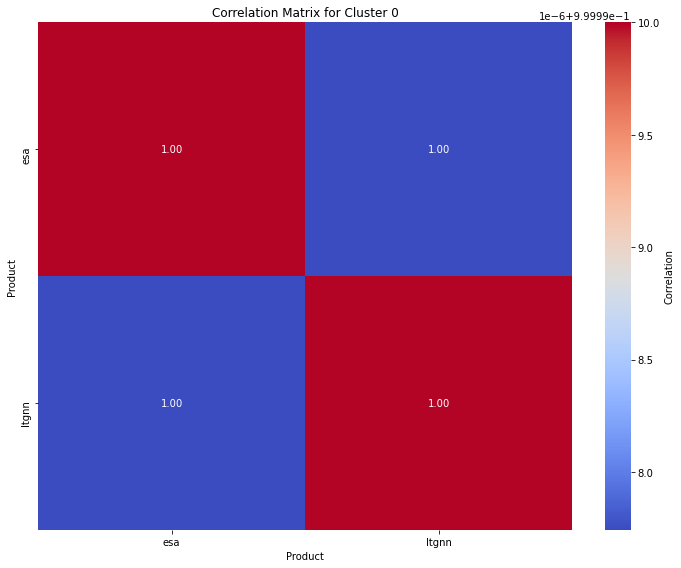

Silhouette Coefficient: -0.014681150764151604
Calinski-Harabasz Index: 1.0001713603673794
Davies-Bouldin Index: 1.4731689070423


In [27]:
#OPTICS clustering
optics = OPTICS(min_samples=2)
clusters = optics.fit_predict(data_scaled)
labels = optics.labels_
print("OPTICS Cluster labels:", clusters)

cluster_distances=get_dist(data_scaled, labels)

# Add cluster labels to the transposed DataFrame
data_transposed.loc[:,'cluster'] = clusters

# Transpose the data back to the original format
biomass_data_clustered = data_transposed.reset_index()

# List of products
products = ['chopping', 'esa', 'gedi', 'gfw', 'harmonized', 'liu', 'ltgnn','menlove','natl','xu']

corr_matrix=plot_heat_by_clus(biomass_data_clustered,products)

# METRICS
# Extract predicted cluster labels
predicted_labels = biomass_data_clustered['cluster']
print_indices(data_scaled, predicted_labels)